In [1]:
# Imports
import math
import torch
import gpytorch
import numpy
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, AdditiveGridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

# See dkl_mnist for toeplitz explanation
gpytorch.functions.use_toeplitz = False
# Inline plotting
%matplotlib inline

In [2]:
# We store the data as a 10k 1D vector
# It actually represents [0,1]x[0,1] in cartesian coordinates
n = 100
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        # Each coordinate varies from 0 to 1 in n=100 steps
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
# Cuda variable the x_data
train_x = Variable(train_x).cuda()
# function is y=sin(x) + 2*pi*cos(x)
train_y = Variable((torch.sin(train_x.data[:, 0]) + torch.cos(train_x.data[:, 1])) * (2 * math.pi)).cuda()

In [3]:
# Use the exact GP model for regression #### NEED MORE INFO ON THIS
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        # Constant mean and RBF kernel
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.base_covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        # Put the AdditiveGridInterpolationKernel over the RBF kernel
        # There are two dimensions (n_components=2)
        self.covar_module = AdditiveGridInterpolationKernel(self.base_covar_module,
                                                            grid_size=400,
                                                            grid_bounds=[(0, 1)],
                                                            n_components=2)
        # Register the lengthscale of the RBF kernel as a parameter to be optimized
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])),
                                bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        # Put the input through the AdditiveGridInterpolationKernel and scale
        # the covariance matrix
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)

# initialize the likelihood and model
likelihood = GaussianLikelihood().cuda()
model = GPRegressionModel(train_x.data, train_y.data, likelihood).cuda()

In [4]:
# Optimize the model
model.train()
likelihood.train()
# optimize using adam
optimizer = optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
optimizer.n_iter = 0
num_iter = 20
for i in range(num_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(likelihood, output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.data[0]))
    optimizer.step()

Iter 1/20 - Loss: 0.926
Iter 2/20 - Loss: 0.825
Iter 3/20 - Loss: 0.726
Iter 4/20 - Loss: 0.627
Iter 5/20 - Loss: 0.527
Iter 6/20 - Loss: 0.428
Iter 7/20 - Loss: 0.330
Iter 8/20 - Loss: 0.230
Iter 9/20 - Loss: 0.131
Iter 10/20 - Loss: 0.032
Iter 11/20 - Loss: -0.067
Iter 12/20 - Loss: -0.168
Iter 13/20 - Loss: -0.264
Iter 14/20 - Loss: -0.362
Iter 15/20 - Loss: -0.461
Iter 16/20 - Loss: -0.559
Iter 17/20 - Loss: -0.656
Iter 18/20 - Loss: -0.756
Iter 19/20 - Loss: -0.848
Iter 20/20 - Loss: -0.945


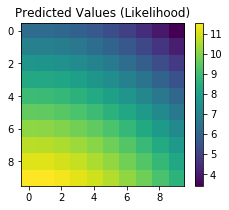

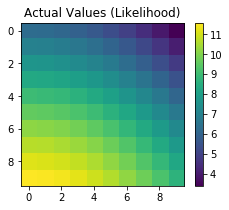

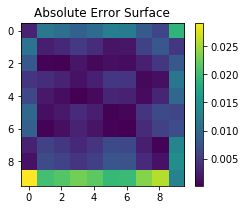

In [5]:
# Set into eval mode
model.eval()
likelihood.eval()

# Create 100 test data points
# Over the square [0,1]x[0,1]
n = 10
test_x = Variable(torch.zeros(int(pow(n, 2)), 2)).cuda()
for i in range(n):
    for j in range(n):
        test_x.data[i * n + j][0] = float(i) / (n-1)
        test_x.data[i * n + j][1] = float(j) / (n-1)

# Put the test data through the model then likelihood
observed_pred = likelihood(model(test_x))
# the mean of the Gaussians are our predicted labels
pred_labels = observed_pred.mean().view(n, n).data.cpu().numpy()

# Calculate the true test values
test_y_actual = ((torch.sin(test_x.data[:, 0]) + torch.cos(test_x.data[:, 1])) * (2 * math.pi))
test_y_actual = test_y_actual.cpu().numpy().reshape(n, n)
# Compute absolute error
delta_y = numpy.absolute(pred_labels - test_y_actual)

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Make a plot of the predicted values
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')
# Make a plot of the actual values
f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')
# Make a plot of the errors
f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')